In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import trange, tqdm
from torchvision import datasets
import torchvision.transforms as transforms

In [2]:
# wine = load_wine(as_frame=True).frame
# X_train, X_val, y_train, y_val = train_test_split(wine.drop(columns = "target"), wine['target'], random_state=44)

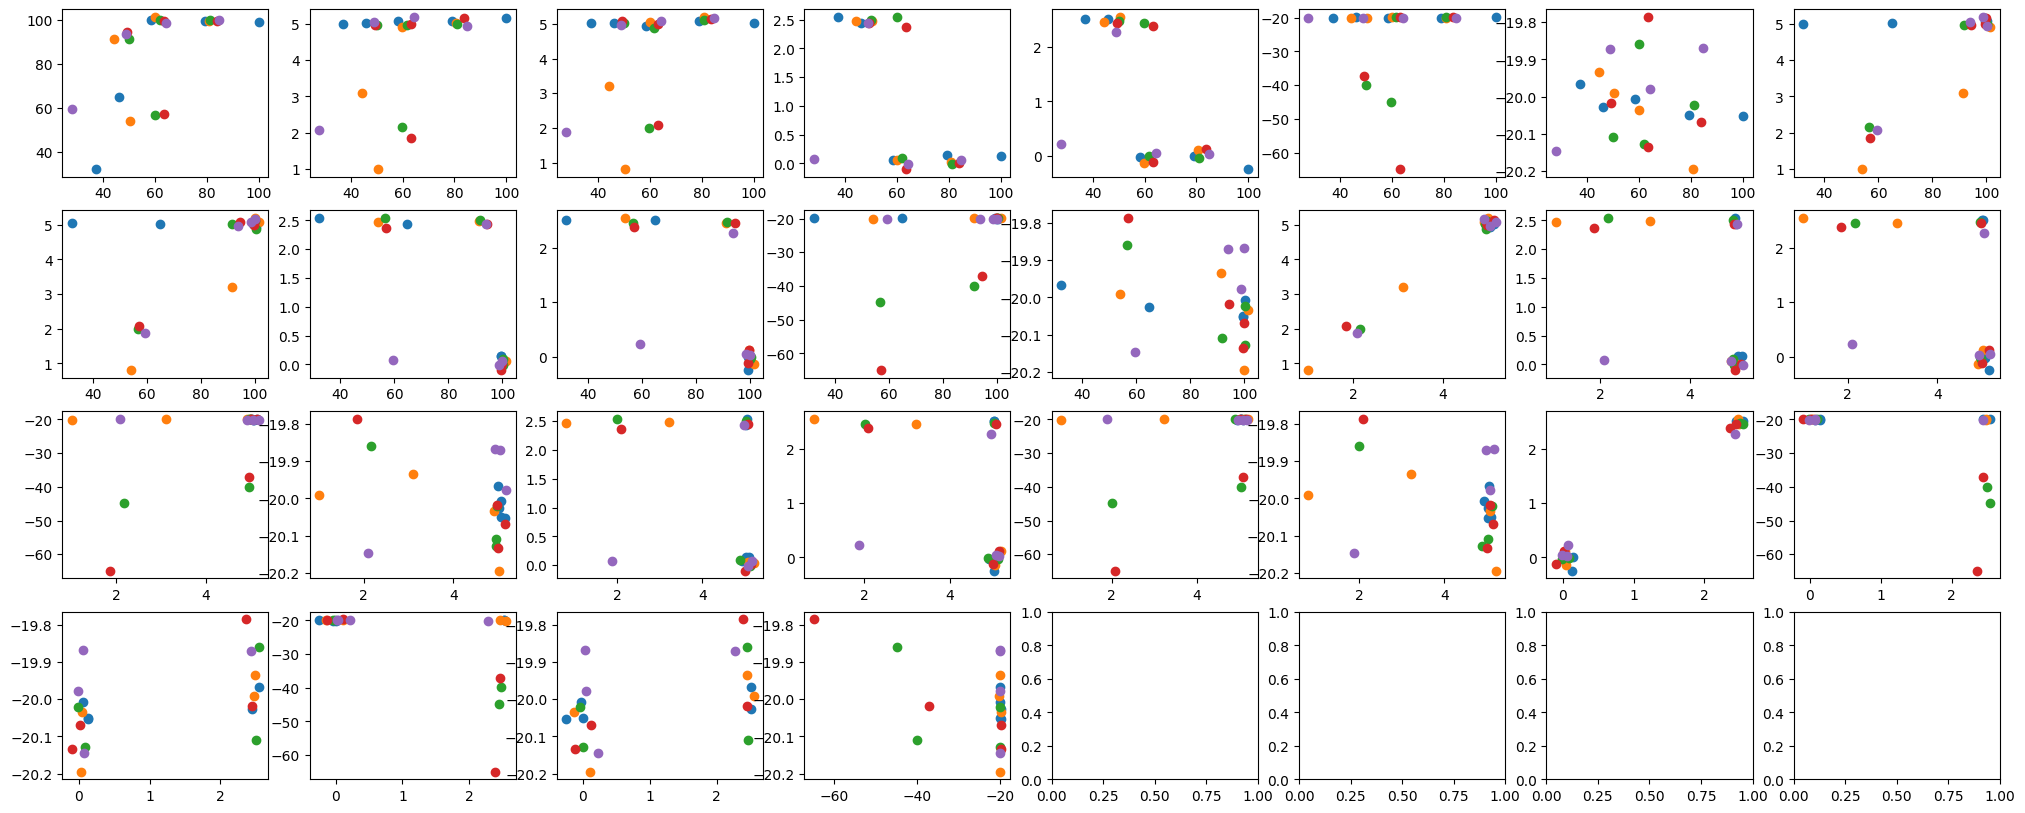

In [170]:
def show_scattering_diagram(df, shape_1, shape_2):
    fig, ax = plt.subplots(shape_1, shape_2)
    fig.set_figheight(10)
    fig.set_figwidth(25)
    for t in df['target'].unique():
        k=0
        for i in range(df.shape[1]-1):
            for j in range(i+1,df.shape[1]-1):
                ax[int(k/shape_2), k % shape_2].scatter(df[df['target']==t].iloc[:,i], df[df['target']==t].iloc[:,j])
                k+=1
show_scattering_diagram(data[::42], 4, 8)

In [196]:
data = list()
lable = list()
for i in range(5):
    d = pd.read_csv(f"data/AircraftFuelDistributionSystem/{i}.csv")
    for j in range(int(d.shape[0]/10)):
        data.append(d[0:d.shape[0]-d.shape[0]%10:int(d.shape[0]/10)].values)
        lable.append(i)
data = np.array(data)
lable = np.array(lable)
X_train, X_val, y_train, y_val = train_test_split(data, lable, random_state=44)

In [11]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.labels = torch.tensor(Y).float()
        self.data = torch.tensor(X).float()
        self.current = 0

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = int(self.labels[idx])
        return data, label
    
    def __iter__(self):
        self.current = 0
        return self
    
    def __next__(self):
        if self.current < self.__len__():
            self.current += 1
            return self.__getitem__(self.current-1)
        raise StopIteration

In [195]:
batch_size = 100

train_data = CustomDataset(X_train, y_train)
test_data = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle= True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle= False)

In [2]:
batch_size = 60
# Загрузка и трансформирование данных
transform = transforms.Compose([transforms.ToTensor()])

train_data = datasets.MNIST(root='data',   train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle= True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle= False)

In [3]:
def init_batch_generator(dataloader: torch.utils.data.DataLoader):
    """
    Возвращает функцию, вызов которой возвращает следующие batch_size
    примеров и им соответствуюющих меток из train_data, train_labels.
    
    Примеры выбираются последовательно, по кругу. Массивы с входными 
    примерами и метками классов перемешиваются в начале каждого круга.
    """
    def f():
        while True:
            for i, (images, labels) in enumerate(dataloader):
                yield images, labels
    return f()

In [100]:
class Classifier(nn.Module):
    def __init__(self,
                 size_in: int = 28**2,
                 size_out: int = 10): 
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(size_in, 28**2)
        self.fc2 = nn.Linear(28**2, 1000)
        self.fc3 = nn.Linear(1000, size_out)
        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout()
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.ReLU(x)
        return x

In [101]:
net = Classifier(28**2, 10)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, nesterov=True)

In [256]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adagrad(net.parameters(), lr=0.0001)

In [37]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)

In [16]:
class Metrics:
    def __init__(self, lables, predicted):
        leble = np.arange(10)
        self.matrix = np.zeros((leble.size, leble.size))
        for i in range(leble.size):
            for j in range(leble.size):
                self.matrix[i, j]=((leble[j]==predicted)*(lables==leble[i])).sum()
    
    def accuracy(self):
        return np.array([self.matrix.diagonal().sum()/self.matrix.sum()
                         if self.matrix.diagonal().sum() != 0 else 0.
                         for i in range(self.matrix.shape[0])])
    def precision(self):
        return np.array([self.matrix[i,i]/self.matrix[i,:].sum()
                         if self.matrix[i,i] != 0 else 0.
                         for i in range(self.matrix.shape[0])])
    def recall(self):
        return np.array([self.matrix[i,i]/self.matrix[:,i].sum()
                         if self.matrix[i,i] != 0 else 0.
                         for i in range(self.matrix.shape[0])])
    def FPR(self):
        return np.array([(self.matrix[i,:].sum()-self.matrix[i,i])/(self.matrix[:,i].sum()+self.matrix[i,:].sum()-2*self.matrix[i,i])
                         if (self.matrix[i,:].sum()-self.matrix[i,i]) != 0 else 0.
                         for i in range(self.matrix.shape[0])])
    def TPR(self):
        return np.array([self.matrix[i,i]/self.matrix[:,i].sum()
                         if self.matrix[i,i] != 0 else 0.
                         for i in range(self.matrix.shape[0])])
    def F(self, b = 1):
        b=b**2
        return (1+b)*self.precision()*self.recall()/(b*self.precision()+self.recall())
    def all(self, b=1):
        return pd.DataFrame(np.array([self.accuracy(), self.precision(), self.recall(), self.FPR(), self.TPR(), self.F(b)]).T,
                            columns=["accuracy", "precision", "recall", "FPR", "TPR", "F"])

In [98]:
def train(net: nn.Module,
          train_loader: torch.utils.data.DataLoader,
          criterion: nn.Module,
          optimizer: torch.optim.Optimizer,
          num_epochs: int = 5):
    net.train()

    data_iterator = init_batch_generator(train_loader)
    test_iterator = init_batch_generator(test_loader)
    progress = trange(num_epochs*len(train_loader))
    loss_arr = list()
    loss_test_arr = list()
    accuracy_arr = list()
    accuracy_test_arr = list()

    for epoch in progress:
        net.train()
        data, labels = next(data_iterator)
        outputs = net(data)
        loss = criterion(outputs, torch.tensor([[ 1. if j == labels[i] else 0. for j in range(10)] for i in range(len(labels))]))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # total = labels.size(0)
        # _, predicted = torch.max(outputs.data, 1)
        # correct = (predicted == labels).sum().item()
        # loss_arr.append(loss.item())
        # accuracy_arr.append(correct / total)

        # progress.set_postfix_str(f"Loss: {loss.item() :.4f}, Accuracy: {(correct / total) * 100 :.2f}%")
        net.eval()

        outputs = net(data)
        loss = criterion(outputs, torch.tensor([[ 1. if j == labels[i] else 0. for j in range(10)] for i in range(len(labels))]))
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        loss_arr.append(loss.item())
        accuracy_arr.append(correct / total)

        data, labels = next(test_iterator)
        outputs = net(data)
        loss = criterion(outputs, torch.tensor([[ 1. if j == labels[i] else 0. for j in range(10)] for i in range(len(labels))]))
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        loss_test_arr.append(loss.item())
        accuracy_test_arr.append(correct / total)

    return loss_arr, accuracy_arr, loss_test_arr, accuracy_test_arr

In [102]:
out = train(net, train_loader, criterion, optimizer, 5)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [84]:
o_l = out
o_l[0].extend(out1[0])
o_l[1].extend(out1[1])
o_l[2].extend(out1[2])
o_l[3].extend(out1[3])

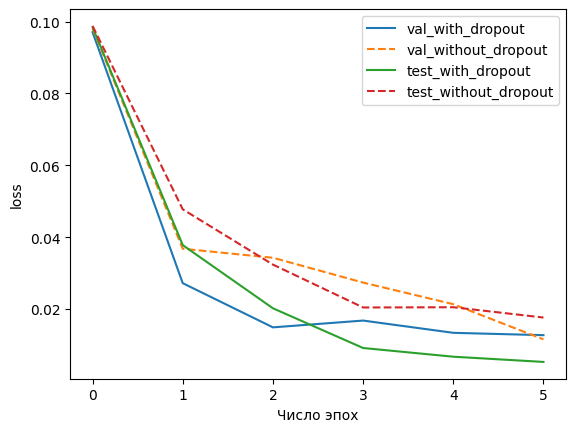

In [103]:
plt.plot(out[0][::999], label="val_with_dropout")
plt.plot(o_l[0][:5000:999], label="val_without_dropout", linestyle='dashed')
plt.plot(out[2][::999], label="test_with_dropout")
plt.plot(o_l[2][:5000:999], label="test_without_dropout", linestyle='dashed')
plt.xlabel('Число эпох')
plt.ylabel('loss')
plt.legend();

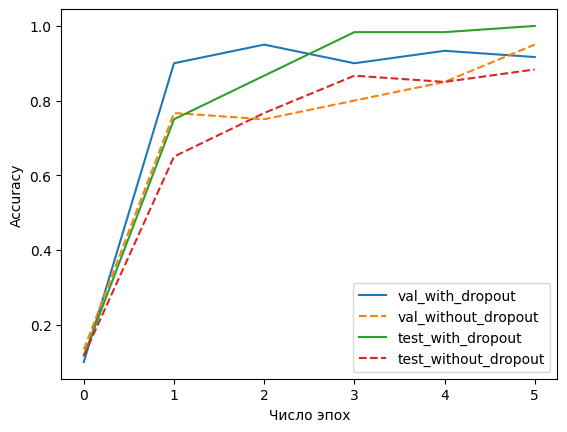

In [104]:
plt.plot(out[1][::999], label="val_with_dropout")
plt.plot(o_l[1][:5000:999], label="val_without_dropout", linestyle='dashed')
plt.plot(out[3][::999], label="test_with_dropout")
plt.plot(o_l[3][:5000:999], label="test_without_dropout", linestyle='dashed')
plt.xlabel('Число эпох')
plt.ylabel('Accuracy')
plt.legend();

In [105]:
labels = list()
pred = list()
for image, lable in train_data:
    _, predicted = torch.max(net(image), 1)
    pred.extend(predicted)
    labels.append(lable)
metrics = Metrics(labels, pred)
metrics.all()

,accuracy,precision,recall,FPR,TPR,F
0,0.942867,0.977207,0.961142,0.365854,0.961142,0.969108
1,0.942867,0.975675,0.962822,0.392344,0.962822,0.969206
2,0.942867,0.925814,0.941940,0.565217,0.941940,0.933807
3,0.942867,0.917142,0.934364,0.562569,0.934364,0.925673
4,0.942867,0.950702,0.926593,0.395604,0.926593,0.938493
5,0.942867,0.917727,0.935854,0.566709,0.935854,0.926702
6,0.942867,0.970598,0.947542,0.353659,0.947542,0.958932
7,0.942867,0.949401,0.952137,0.514610,0.952137,0.950767
8,0.942867,0.922919,0.927835,0.517796,0.927835,0.925371
9,0.942867,0.915448,0.933653,0.565169,0.933653,0.924461


In [69]:
torch.save(net.state_dict(), "wights.ckpt")